Final Time: 1.006126813


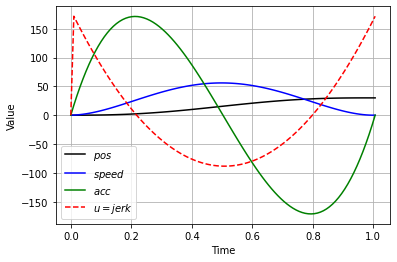

In [14]:
try:
    from gekko import GEKKO
except:
    print("Installing GEKKO...")
    !pip install GEKKO
    from gekko import GEKKO

import numpy as np
import matplotlib.pyplot as plt

m = GEKKO() # initialize gekko
nt = 101
m.time = np.linspace(0,1,nt)

# Constants
xi = 0
xf = 30
vi = 0
vf = 0
ai = 0
af = 0


# Create Variables + plug init values
x = m.Var(value=xi)
v = m.Var(value=vi)
a = m.Var(value=ai)
u = m.Var(fixed_initial=False)

# create end point (so we can do operations/set constraints that only affect the end point)
p = np.zeros(nt) # mark final time point
p[-1] = 1.0
final = m.Param(value=p)


# Variables. I don't really get the difference. But this way works.
# https://gekko.readthedocs.io/en/latest/quick_start.html?highlight=manipulated#variable-types
# FV = fixed variable, only one value over the time horizon
tf = m.FV(value=1.0,lb=0.1,ub=100.0)
tf.STATUS = 1
# MV = manipulated variable / time-dependent, adjustable at all time points in the time horizon
u = m.MV(value=0,lb=-1e8,ub=1e8) #lb and ub are super high
u.STATUS = 1



# State vector dynamics
# tau = 1.8
# m.Equation(x.dt()==v*tf)
# m.Equation(v.dt()==a*tf - (v*tf)/tau) # (v*tf)/tau or v/tau ?
# m.Equation(a.dt()==u*tf)
# is the same as:
tau = 1.8
m.Equation(x.dt()/tf ==v)
m.Equation(v.dt()/tf ==a)# - v/tau) # but removes this ambiguity
m.Equation(a.dt()/tf ==u)

# final time constraints
m.Equation(x*final == xf*final) # or m.Equation((x-xf)*final >= 0)
m.Equation(v*final == vf*final)
m.Equation(a*final == af*final)

# other way of setting final time constraints
# m.Minimize(final*1e5*(x-xf)**2)
# m.Minimize(final*1e5*(v-vf)**2)


# define costs
movement_cost = m.integral(u**2)*final
Rwd = 1
time_cost = Rwd-(Rwd/(1+tf))
#time_cost = tf

# Define objective: minimize movement and time costs. Playing with big constants for now, but it seems to work.
m.Obj(1 * movement_cost + 150000 * time_cost) # Objective function

# ==> I'll do something like: m.Obj(alpha * movement_cost + beta * time_cost)

# change "sensitivity to time" => get shorter/longer run
# m.Obj(movement_cost + 100000*time_cost) # Objective function
# m.Obj(movement_cost + 200000*time_cost) # Objective function

# solve OCP
m.options.IMODE = 6 # optimal control mode
m.solve(disp=False) # solve
print('Final Time: ' + str(tf.value[0]))
m.time = m.time * tf.value[0]

# plot results (pos, speed, acc, jerk)
plt.figure(1) # plot results
plt.grid()
plt.plot(m.time,x.value,'k-',label=r'$pos$')
plt.plot(m.time,v.value,'b-',label=r'$speed$')
plt.plot(m.time,a.value,'g-',label=r'$acc$')
plt.plot(m.time,[v/10 for v in u.value],'r--',label=r'$u=jerk$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  app.launch_new_instance()


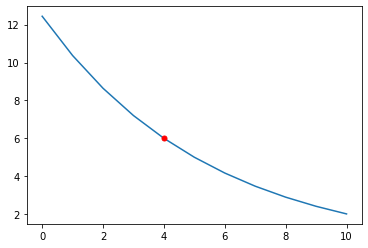

In [5]:
# what if simulation must arrive at intermediate values along the time horizon?
# e.g. maxspeed time
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt
m = GEKKO(remote=False)
m.time = np.linspace(0,10,11)
x = m.Var(np.zeros(11)*6,fixed_initial=False)
m.Equation(5*x.dt() == -x)
pi = np.zeros(11)
pi[4]=1
p = m.Param(pi)

m.Minimize(p*(x-6)**2)
m.options.IMODE = 6
m.solve(disp=False)
plt.plot(m.time, x.value)
plt.plot([4],[6],'ro',MarkerSize=5)
plt.show()